# Multinomial Naive Bayes Machine Learning Algorithm
Predicting subreddit class from a body of text and title using Multinomial Naive Bayes Machine Learning Algorithm from scratch

## Import Libraries and Functions
- Import libraries
- Import stopwords
- Import utility functions
- Set pandas options and settings

In [1]:
# * Import libraries
from sklearn.metrics import confusion_matrix, classification_report
from nltk.tokenize import word_tokenize
from datetime import datetime
from collections import Counter
from pandas import DataFrame
from numpy import int64
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pathlib
import re
import os

cleaning_regex = re.compile(r"[^\w\s]")
current_path = str(pathlib.Path().resolve())

dataset_dir = f'{current_path}\\datasets\\'
model_dir = f'{current_path}\\models\\scratch\\'
classification_report_dir = f'{current_path}\\metrics\\classification-report\\scratch\\'
confusion_matrix_dir = f'{current_path}\\metrics\\confusion-matrix\\scratch\\'

# * Import stopwords
print(f'Loading English and Tagalog stopwords...')
eng_file_path = f'{current_path}\\stopwords\\english_stopwords.txt'
tag_file_path = f'{current_path}\\stopwords\\tagalog_stopwords.txt'
eng_stop = set()
tag_stop = set()

with open(eng_file_path, 'r') as f:
    for i, line in enumerate(f):
        eng_stop.add(line.replace('\n', ''))

with open(tag_file_path, 'r') as f:
    for i, line in enumerate(f):
        tag_stop.add(line.replace('\n', ''))

# * Import utility functions
def timestamp_str_to_epoch(time='2024-01-01 00:00:00') -> int:
    """ Converts timestamp in string to epoch integer, GMT +local is applied """
    return int(datetime.strptime(time, '%Y-%m-%d %H:%M:%S').timestamp())

def save_model(model: DataFrame):
    """ Save the model as a CSV file """
    existing_files = [f for f in os.listdir(model_dir)]
    id = len(existing_files) + 1
    model.to_csv(f'{model_dir}\\mnb_model_scratch{id}.csv')
    print(f'Model saved as mnb_model_scratch{id}.csv...')

def save_classification_report(report: str | dict):
    """ Save classification report as a text file """
    existing_files = [f for f in os.listdir(classification_report_dir)]
    id = len(existing_files) + 1
    with open(f'{classification_report_dir}\\mnb_report_scratch{id}.txt', 'w') as f:
        f.write(report)
    print(f'Classification report saved as mnb_report_scratch{id}.txt...')

def save_confusion_matrix(fig):
    """ Save confusion matrix as a PNG file """
    existing_files = [f for f in os.listdir(confusion_matrix_dir)]
    id = len(existing_files) + 1
    fig.savefig(f'{confusion_matrix_dir}\\mnb_conf_matrix_scratch{id}.png', dpi=1200, bbox_inches='tight')
    print(f'Confusion matrix saved as mnb_conf_matrix_scratch{id}.png...')

# * Set pandas options and settings
# Set option for printing out the maximum rows and column
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 30)

# Set option for increasing display width
pd.set_option('display.width', 30)
pd.set_option('display.max_colwidth', 30)

Loading English and Tagalog stopwords...


## Implement Transform and Cleaning Method
- Function implementation for transforming and cleaning the datasets
- Function implementation for transforming and cleaning a time-based datasets

In [2]:
# * Function implementation for transforming and cleaning the datasets

def import_transform_datasets(
        classes: list[str], 
        n_sample: int, 
        eval_portion: float, 
        dataset_path: str) -> tuple[dict, dict]:
    """ Transform and clean the dataset for each class, returns training and validation dataframe """

    df_list: dict[str, DataFrame] = {}
    d_types ={
        'title': object, 
        'text_content': object, 
        'created_utc': int64, 
        'subreddit_subscribers': int64, 
        'author': object, 
        'author_id': object, 
        'hash_sha256': object, 
        'url_link': object 
    }
    
    # Import the dataframe from a CSV file
    print('Importing the dataset...')
    df_temp = []
    for c in classes:
        df = pd.read_csv(f'{dataset_path}\\{c}_submissions.csv', index_col='id', dtype=d_types)
        df['subreddit'] = c
        df_temp.append(df)
    
    df_temp = pd.concat(df_temp)
    # Remove duplicated title and text content for all classes
    df_temp = df_temp.loc[~df_temp.duplicated(subset=['text_content', 'title'], keep=False)]
    for c in classes:
        df_list[c] = df_temp[df_temp['subreddit'] == c]
    df_temp = []

    # Merge title and text content into one block of text
    print('Merging title and text content...')
    for c, df in df_list.items():
        df_list[c]['text_content'] = df['title'].fillna('') + ' ' + df['text_content'].fillna('')
        df_list[c] = df[['text_content']]
    
    # Gather n variable number of sample from each class
    print(f'Gathering {n_sample} sample from the dataset...')
    for c, df in df_list.items():
        df_list[c] = df.sample(n=n_sample)
    
    # Split the sample dataset into training and validation dataset
    training_df: dict[str, DataFrame] = {}
    validation_df: dict[str, DataFrame] = {}

    eval_sample_len = int(n_sample * eval_portion)
    train_sample_len = n_sample - eval_sample_len
    print(f'Splitting the sample dataset into training ({train_sample_len}) and validation dataset ({eval_sample_len})...')
    for c, df in df_list.items():
        training_df[c], validation_df[c] = df[:train_sample_len], df[train_sample_len:n_sample]
    
    # Tokenize the corpus
    print('Tokenizing the corpus...')
    for c, df in training_df.items():
        df_copy = df.copy() # Create a copy to avoid setting on a slice

        df_copy.loc[:, 'tokens'] = df_copy['text_content'].str.lower()
        df_copy.loc[:, 'tokens'] = df_copy['tokens'].str.replace(cleaning_regex, ' ', regex=True)
        df_copy.loc[:, 'tokens'] = df_copy['tokens'].apply(lambda x: ' '.join([
            token for token in word_tokenize(x)
            if len(token) > 2 and token not in eng_stop and token not in tag_stop]))

        training_df[c] = df_copy # Update the training_df with the modified copy

    for c, df in validation_df.items():
        df_copy = df.copy() # Create a copy to avoid setting on a slice

        df_copy.loc[:, 'tokens'] = df_copy['text_content'].str.lower()
        df_copy.loc[:, 'tokens'] = df_copy['tokens'].str.replace(
            cleaning_regex, ' ', regex=True)
        df_copy.loc[:, 'tokens'] = df_copy['tokens'].apply(lambda x: ' '.join([
            token for token in word_tokenize(x)
            if len(token) > 2 and token not in eng_stop and token not in tag_stop]))
        
        validation_df[c] = df_copy # Update the validation_df with the modified copy
    
    return (training_df, validation_df)

# * Function implementation for transforming and cleaning a time-based datasets
def transform_time_based_dataset(df_train: DataFrame, df_validation: DataFrame) -> tuple[DataFrame, DataFrame]:
    """ Transform and clean a single time-based pre-processed dataset from a class, returns training and validation dataframe"""

    # Merge title and text content into one block of text
    print('Merging title and text content...')
    df_train['text_content'] = df_train['title'].fillna('') + ' ' + df_train['text_content'].fillna('')
    df_train = df_train[['created_utc', 'text_content']]
    df_validation['text_content'] = df_validation['title'].fillna('') + ' ' + df_validation['text_content'].fillna('')
    df_validation = df_validation[['created_utc', 'text_content']]

    # Tokenize the corpus
    print('Tokenizing the corpus...')
    df_train_copy = df_train.copy()  # Create a copy to avoid setting on a slice
    df_validation_copy = df_validation.copy()

    df_train_copy.loc[:, 'tokens'] = df_train_copy['text_content'].str.lower()
    df_train_copy.loc[:, 'tokens'] = df_train_copy['tokens'].str.replace(cleaning_regex, ' ', regex=True)
    df_train_copy.loc[:, 'tokens'] = df_train_copy['tokens'].apply(lambda x: ' '.join([
        token for token in word_tokenize(x)
        if len(token) > 2 and token not in eng_stop and token not in tag_stop]))
    
    df_validation_copy.loc[:, 'tokens'] = df_validation_copy['text_content'].str.lower()
    df_validation_copy.loc[:, 'tokens'] = df_validation_copy['tokens'].str.replace(cleaning_regex, ' ', regex=True)
    df_validation_copy.loc[:, 'tokens'] = df_validation_copy['tokens'].apply(lambda x: ' '.join([
        token for token in word_tokenize(x)
        if len(token) > 2 and token not in eng_stop and token not in tag_stop]))

    return (df_train_copy, df_validation_copy)

## Implement Model Training
- Function implementation for training the model

### Training using Maximum Likelihood
The likelihood of a class can be estimated by maximizing the probability of a term $x_i$ given the class $C$
<br>
<br>
$\large P(x_i|C)$

Maximizing the probability:
- Count the occurrences of all terms $X_c = x_{ci},...,x_{cn}$ for each class $C$ where $x_{ci}$ is the frequency of each term $i$ given a class $C$
- The probability of each term $x_{ci}$ given classs $C$ is calculated as:
<br>
$ P(x_i|C) = \Large \frac{x_{ci}\ +\ \alpha}{X_c\ +\ \alpha n}$
    <br>
    Where:
    - Setting alpha value $\alpha = 1$ is called Laplace smoothing, which prevents zero probabilities by adding 1 to all term counts
    - $X_c = \sum_{i=1}^{n}X_{ci}$ is the sum of frequency of all terms found in a class
- Logarithms are applied to stabilize the computation and prevent precision issues, instead of directly multiplying probabilities
<br>
<br>
$ log(P(x_1|C)\times P(x_2|C)) = log(P(x_1|C)) + log(P(x_2|C))$
<br>
<br>
Logarithms convert multiplication into addition
<br>
<br>
$\large e^{log(P(x_1|C)\times P(x_2|C))} =\small P(x_1|C)\times P(x_2|C)$
<br>
<br>
and exponentiating the logarithms yields the original product of probabilities


### Implementation

In [3]:
# * Function implementation for training the model
def train(training_df: dict[str, DataFrame]) -> DataFrame:
    """ Returns the likelihood of each term for each class """
    print('Training the model...')
    all_token_counters = {}

    # Count the occurences of all terms
    for c, df in training_df.items():
        token_counter = Counter()
        df['tokens'].apply(lambda x: token_counter.update(x.split(' ')))
        all_token_counters[c] = token_counter
    
    # Create a vocabulary of terms
    all_terms = set()
    for counter in all_token_counters.values():
        all_terms.update(counter.keys())

    data = []
    for term in all_terms:
        row = {'term': term}
        
        # Map the number of times a term appears in a class
        for c in training_df.keys():
            row[f'{c}_count'] = all_token_counters[c].get(term, 0)
        data.append(row)
    
    likelihoods_df = pd.DataFrame(data)
    likelihoods_df = likelihoods_df.set_index('term')

    # Apply laplace smoothing to prevent zero probabilities
    for c in training_df.keys():
        likelihoods_df[f'{c}_count'] = likelihoods_df[f'{c}_count'].apply(lambda x: x + 1)
    
    # Apply logarithm for each likelihood to stabilize training
    for c in training_df.keys():
        total_c = likelihoods_df[f'{c}_count'].sum()
        likelihoods_df[f'{c}'] = np.log(likelihoods_df[f'{c}_count'] / total_c)
        likelihoods_df = likelihoods_df.drop([f'{c}_count'], axis=1)
    
    return likelihoods_df

## Implement Prediction and Evaluation Method
- Function implementation for predicting the class given the text
- Function implementation for evaluating the model

### Prediction by Maximizing the Likelihood
The probability of a document $d$ beloging to class $C_i$ is given by:

- Maximizing the likelihood:
    <br>
    <br>
    $\large P(C_i|d) \propto P(C_i)\prod_{i=1}^{n}P(x_i|C_i)$
    <br>
    <br>
    In this formula, the probability of a class $C_i$ given the document $d$ is proportional to prior probability (base rate) and the joint probability of the terms in the document given the class (likelihood)
    <br>
    Where:
    - $P(C_i)$ is the prior probability or prevalence of a class $C_i$
    - $P(x_i|C_i)$ is the probability of a term $x_i$ given class $C_i$
    - $n$ is the total number of terms in document $d$
    <br>
- Final Decision: The classifier assigns the document to the class $C_i$ that maximizes $P(C_i|d)$
<br>
<br>
$\^C = \underset{C}{\operatorname{argmax}} [log(P(C_i)) + \sum_{i=1}^{n}log(P(x_i|C_i))]$
<br>
<br>
    - Taking the logarithm of probabilities (log-likelihood) helps in numerical stability and simplifies calculations, turning products into sums.
    - The classifier predicts the class that has the highest log-probability score.
<br>
- Since the prevalence of a class in this project will always be equally distributed, the algorithm can be simplified
<br>
<br>
$\^C = \underset{C}{\operatorname{argmax}} [\sum_{i=1}^{n}log(P(x_i|C_i))]$

### Implementation

In [4]:
# * Function implementation for predicting the class given the text
def predict(token: str, classes: list[str], likelihoods_df: DataFrame) -> str:
    """ Returns the predicted class """
    max_likelihood = {}

    # Maximize the likelihood for each class
    for c in classes:
        max_likelihood[c] = 1

        # Calculate the maximum likelihood estimate for a class
        for i in token.split(' '):
            if i in likelihoods_df.index:
                # Sum the logarithm of probabilities (log-likelihood)
                max_likelihood[c] += likelihoods_df.loc[i][c]
    
    # Yield the class that has the highest log-probability score
    prediction = max(max_likelihood, key=max_likelihood.get)
    return prediction

# * Function implementation for evaluating the model
def evaluate(
        classes: list[str], 
        likelihoods_df: DataFrame, 
        validation_df: dict[str, DataFrame]) -> tuple[list, list]:
    """ Return the list of actual labels and the predicted labels  """
    print('Evaluating the model...')
    actuals = []
    predictions = []

    # Loop through each class and its corresponding validation dataframe
    for c in list(validation_df.keys()):
        df = validation_df[c]
        
        # Loop through each row in the validation dataframe
        for _, row in df.iterrows():
            text = row['tokens']
            # Predict the label
            predicted_label = predict(text, classes, likelihoods_df) 

            # Append the actual label and the predicted label in the list
            actuals.append(c)
            predictions.append(predicted_label)

    # Return the list of actual labels and the predicted labels
    return (actuals, predictions)
    

## Main Entrypoint
After implementing data transformation, cleaning process and the algorithm. Proceed to processing the dataset, train the model, and then evaulate the model 
- Data Preparation and Pre-processing
    - Random-Based Dataset Splitting
    - Time-Based Dataset Splitting
- Training, Evaluation and Prediction
    - Training
    - Evaluation
    - Prediction

### Data Preparation and Pre-processing
Select either random-based or time-based dataset splitting

#### Random-Based Dataset Splitting
Splitting dataset to training and validation datasets

In [5]:
# Transform and clean the dataset

dataset_path = f'{dataset_dir}2024\\'

classes = [
    'DeepThoughts', 
    'CryptoCurrencies', 
    'askphilosophy', 
    'computerscience',
    'LawSchool', 
    'Wallstreetbetsnew', 
    'PoliticalDiscussion', 
    'geopolitics'
]

# Where eval_portion is the proportion (20%) of validation dataset that will be taken from the sample dataset
# ! If this causes an error due to small sample size, reduce the number for n_sample
df_train, df_valid = import_transform_datasets(classes=classes, n_sample=2000, eval_portion=.2, dataset_path=dataset_path)
# df_train and df_valid is a dictionary which contains the following: [Class (string), Dataset (Dataframe)]

Importing the dataset...
Merging title and text content...
Gathering 2000 sample from the dataset...
Splitting the sample dataset into training (1600) and validation dataset (400)...
Tokenizing the corpus...


In [6]:
# * Inspect the training dataset
# pd.set_option('display.width', 1000)
# pd.set_option('display.max_colwidth', 1000)

df_train['computerscience']

,text_content,tokens
id,,
7241,Whats the best video to ex...,whats video explain pointe...
121,Books for android rom deve...,books android rom developm...
3850,How to find a thesis idea?...,thesis idea everyone year ...
8181,Whats the most trusted yet...,whats trusted yet cheap co...
4787,Computer science vs Nursing,computer science nursing
...,...,...
4864,"Join ""The CS50 Movement"" -...",join cs50 movement gateway...
1322,ELI5 : Replication in Dist...,eli5 replication distribut...
1842,Should We Still Contribute...,contribute open source con...


In [7]:
# * Inspect the validation dataset

df_valid['computerscience']

,text_content,tokens
id,,
4385,Editor and coding available,editor coding available
1049,Seeing Intel removing avx ...,seeing intel removing avx ...
5008,Need help identifying mean...,need identifying meaning h...
6171,Which Ipad should i get fo...,ipad computer science
4995,"In microprocessors, why is...",microprocessors rep instru...
...,...,...
5384,Anyone interested in build...,anyone interested building...
6699,Advice for specialty,advice specialty
1115,Surface pro 4 shaking scre...,surface pro shaking screen...


In [8]:
# * Inspect for any duplication of data from training and validation dataset
# Ensure unique rows for training and validation dataset

df_train_and_valid = pd.concat(list(df_train.values()) + list(df_valid.values()))
df_train_and_valid.loc[df_train_and_valid.duplicated(subset=['text_content', 'tokens'], keep=False)]

,text_content,tokens
id,,


#### Time-Based Dataset Splitting
Dataset splitted in training and validation dataset based on the date of submission

In [155]:
# Import and pre-process the dataframe
dataset_path = f'{dataset_dir}\\2024\\'

classes = [
    'DeepThoughts', 
    'CryptoCurrencies', 
    'askphilosophy', 
    'computerscience',
    'LawSchool', 
    'Wallstreetbetsnew', 
    'PoliticalDiscussion', 
    'geopolitics'
]

df_list: dict[str, DataFrame] = {}
df_train: dict[str, DataFrame] = {}
df_valid: dict[str, DataFrame] = {}

d_types ={
    'title': object, 
    'text_content': object, 
    'created_utc': int64, 
    'subreddit_subscribers': int64, 
    'author': object, 
    'author_id': object, 
    'hash_sha256': object, 
    'url_link': object 
}

print('Importing the dataset...')
df_temp = []
for c in classes:
    df = pd.read_csv(f'{dataset_path}\\{c}_submissions.csv', index_col='id', dtype=d_types)
    df['subreddit'] = c
    df_temp.append(df)
df_temp = pd.concat(df_temp)

# Remove duplicated title and text content for all classes
df_temp = df_temp.loc[~df_temp.duplicated(subset=['text_content', 'title'], keep=False)]

for c in classes:
    df_list[c] = df_temp[df_temp['subreddit'] == c]

# Split the dataset into training and validation by date of submission
print('Splitting dataset into training and validation dataset')
jan2024 = timestamp_str_to_epoch(time='2024-01-01 00:00:00')
june2024 = timestamp_str_to_epoch(time='2024-06-01 00:00:00')

df_stats = pd.DataFrame(columns=['subreddit', 'training', 'validation'])
# Dataset between January 2024 and June 2024 is use for training, while dataset beyond June 2024 is for validation
for c in classes:
    # Condition the dataset
    condition_train = (df_list[c]['created_utc'] > jan2024) & (df_list[c]['created_utc'] < june2024)
    df_train[c] = df_list[c][condition_train]
    df_valid[c] = df_list[c][~condition_train]

    # For statistical purposes
    new_row = pd.DataFrame({
        'subreddit': [c], 
        'training': [df_train[c].shape[0]], 
        'validation': [df_valid[c].shape[0]]
    })
    df_stats = pd.concat([df_stats, new_row], ignore_index=True)

# Get the minimum size of rows for each training and validation dataset to sample a balance number of rows for each class
print(f'\nSizes:\nTraining minimum: {df_stats["training"].min()}\nValidation minimum: {df_stats["validation"].min()}')
df_stats

Importing the dataset...
Splitting dataset into training and validation dataset

Sizes:
Training minimum: 1649
Validation minimum: 1282


,subreddit,training,validation
0,DeepThoughts,3849,4853
1,CryptoCurrencies,1970,1622
2,askphilosophy,8919,6927
3,computerscience,4908,3065
4,LawSchool,10671,8318
5,Wallstreetbetsnew,1649,1282
6,PoliticalDiscussion,5806,8391
7,geopolitics,4871,3436


In [156]:
# Now that we have an idea of the minimum of rows for each training and validation dataset
# Sample n variable number of rows from each class for use in training and validation
for c in classes:
    # Set sample size less than the minimum
    df_train[c] = df_train[c].sample(n=1500)
    df_valid[c] = df_valid[c].sample(n=500)

# Transform and clean the dataset
for c in classes:
    df_train[c], df_valid[c] = transform_time_based_dataset(df_train=df_train[c], df_validation=df_valid[c])

Merging title and text content...
Tokenizing the corpus...
Merging title and text content...
Tokenizing the corpus...
Merging title and text content...
Tokenizing the corpus...
Merging title and text content...
Tokenizing the corpus...
Merging title and text content...
Tokenizing the corpus...
Merging title and text content...
Tokenizing the corpus...
Merging title and text content...
Tokenizing the corpus...
Merging title and text content...
Tokenizing the corpus...


In [157]:
# Inspect the training dataset
# pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 30)

df_train['computerscience'].sort_values(by=['created_utc'])

,created_utc,text_content,tokens
id,,,
1,1704069888,21 y.o. and debating on go...,debating back school compu...
3,1704070245,Laptop Help Needed,laptop needed
9,1704103782,Entry level is insane in 2...,entry level insane 2024 po...
15,1704116466,What is you strategy to ge...,strategy job starting 1st ...
18,1704119120,What should i learn to lan...,learn land internship guys...
...,...,...,...
5224,1717123024,[Help] Could someone pleas...,someone understand time sp...
5228,1717139714,Simple software for attend...,simple software attendance...
5230,1717145249,Readers Writers concurrenc...,readers writers concurrenc...


In [158]:
# Inspect the validation dataset

df_valid['computerscience'].sort_values(by=['created_utc'])

,created_utc,text_content,tokens
id,,,
5250,1717208230,Ways to get into data scie...,ways data science
5252,1717218970,Sensor GPR.,sensor gpr
5258,1717260296,CPU test,cpu test
5287,1717357481,Does every different famil...,different family cpu requi...
5305,1717414257,implications of making an ...,implications making person...
...,...,...,...
8444,1727647576,In need of someone with a ...,need someone mathematical ...
8458,1727692281,checking for VTX virtualiz...,checking vtx virtualizatin...
8463,1727703812,can I watch cs50 after lea...,watch cs50 learning html c...


In [159]:
# Inspect for any duplication of data from training and validation dataset
# Ensure unique rows for training and validation dataset

df_train_and_valid = pd.concat(list(df_train.values()) + list(df_valid.values()), ignore_index=True)
df_train_and_valid.loc[df_train_and_valid.duplicated(subset=['text_content', 'tokens'], keep=False)]

,created_utc,text_content,tokens


### Training, Evaluation and Prediction

#### Training

In [9]:
# Train the model
likelihoods_df = train(training_df=df_train)
# Inspect the learned parameters
likelihoods_df.sort_values(by=['computerscience'], ascending=False)
# Save the model (optional)
# save_model(likelihoods_df)

Training the model...


,DeepThoughts,CryptoCurrencies,askphilosophy,computerscience,LawSchool,Wallstreetbetsnew,PoliticalDiscussion,geopolitics
term,,,,,,,,
computer,-9.689153,-10.128090,-8.565818,-5.006448,-8.574488,-8.034543,-11.011836,-11.252729
science,-7.743243,-10.821237,-6.930627,-5.315313,-7.992567,-8.966101,-9.402398,-9.866434
need,-6.218963,-6.992596,-6.684032,-5.768878,-6.220610,-6.346462,-7.644540,-7.563849
data,-8.639331,-7.930865,-8.443215,-5.850371,-8.523195,-6.449646,-8.932394,-9.460969
time,-5.571278,-7.265889,-5.860670,-6.008460,-5.488242,-6.265773,-6.852953,-6.962269
...,...,...,...,...,...,...,...,...
drezner,-11.635063,-10.821237,-11.701312,-11.206957,-11.518927,-12.224197,-11.011836,-10.559582
azaleas,-11.635063,-10.128090,-11.701312,-11.206957,-11.518927,-12.224197,-11.011836,-11.252729
tolerance,-10.248769,-10.128090,-11.701312,-11.206957,-10.825780,-10.278287,-11.011836,-11.252729


#### Evaluation

In [10]:
# Evaluate the model
(actuals, predictions) = evaluate(classes, likelihoods_df, df_valid)
# Classification report
report = classification_report(actuals, predictions)
# Save report (optional)
# save_classification_report(report)
print(report)

Evaluating the model...
                     precision    recall  f1-score   support

   CryptoCurrencies       0.89      0.69      0.78       400
       DeepThoughts       0.61      0.76      0.68       400
          LawSchool       0.74      0.88      0.81       400
PoliticalDiscussion       0.88      0.65      0.74       400
  Wallstreetbetsnew       0.74      0.80      0.77       400
      askphilosophy       0.70      0.78      0.74       400
    computerscience       0.87      0.77      0.81       400
        geopolitics       0.86      0.84      0.85       400

           accuracy                           0.77      3200
          macro avg       0.79      0.77      0.77      3200
       weighted avg       0.79      0.77      0.77      3200



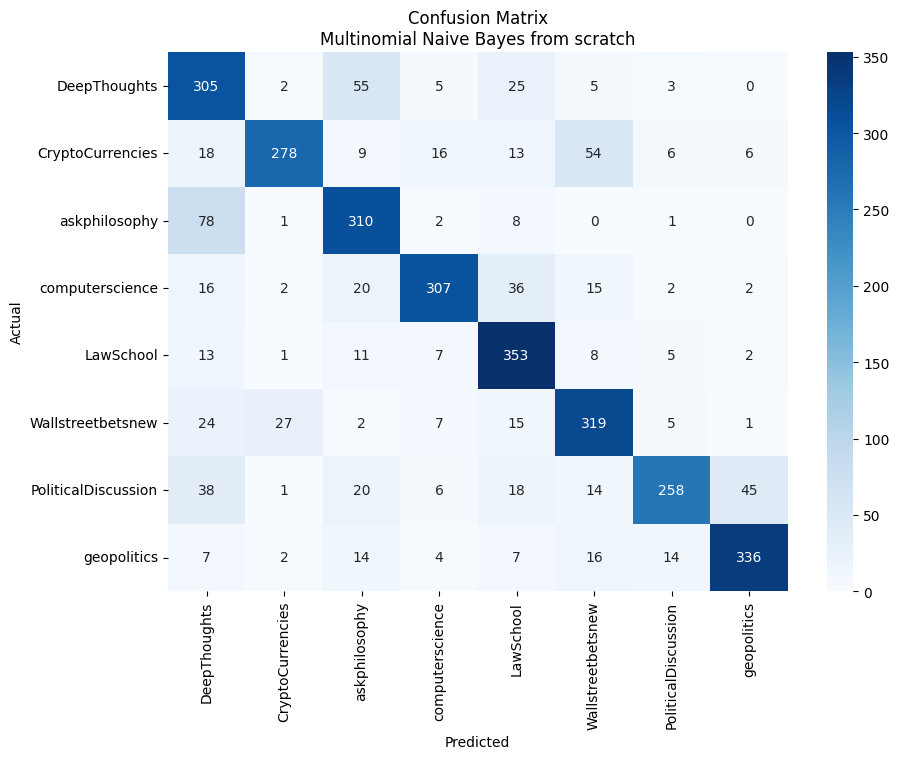

In [11]:
# Confusion matrix
cm = confusion_matrix(actuals, predictions, labels=classes)
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix\nMultinomial Naive Bayes from scratch')
plt.show()
# Save confusion matrix (optional)
# save_confusion_matrix(fig)

#### Prediction

In [ ]:
# Paste the body of text and/or title from a submission
text = """ """
predict(text, classes, likelihoods_df)